# Gaussian Mixture Model Segmentation

# 1. Imports

In [235]:
import cv2
import numpy as np
import seaborn as sns
from kneed import KneeLocator
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# 2. Load Image & Convert RGB

In [236]:
img = cv2.imread('../datasets/base_dataset_iarc_cropped/001_cropped/abnormal/AAE1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 3. Convert to LAB & Split Channel

In [237]:
lab_cv2 = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab_cv2)

# 4. Preprocessing L Channel (CLAHE + Bilateral Blur)

In [238]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
L_clahe = clahe.apply(L)

L_blur = cv2.bilateralFilter(L_clahe, d=9, sigmaColor=75, sigmaSpace=75)

# 5. Prepare Data for GMM

In [239]:
X = L_blur.reshape(-1, 1)

# 6. BIC &&AIC For Multiple K 

In [240]:
ks = range(1, 10)
bics, aics = [], []

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X)
    bics.append(gmm.bic(X))
    aics.append(gmm.aic(X))

# 7. Find Elbow Using Kneed

In [241]:
knee_bic = KneeLocator(ks, bics, curve='convex', direction='decreasing')
knee_aic = KneeLocator(ks, aics, curve='convex', direction='decreasing')

print(f"Optimal K by BIC Elbow: {knee_bic.knee}")
print(f"Optimal K by AIC Elbow: {knee_aic.knee}")

Optimal K by BIC Elbow: 3
Optimal K by AIC Elbow: 3


# 8. Visualize BIC/AIC with elbow point

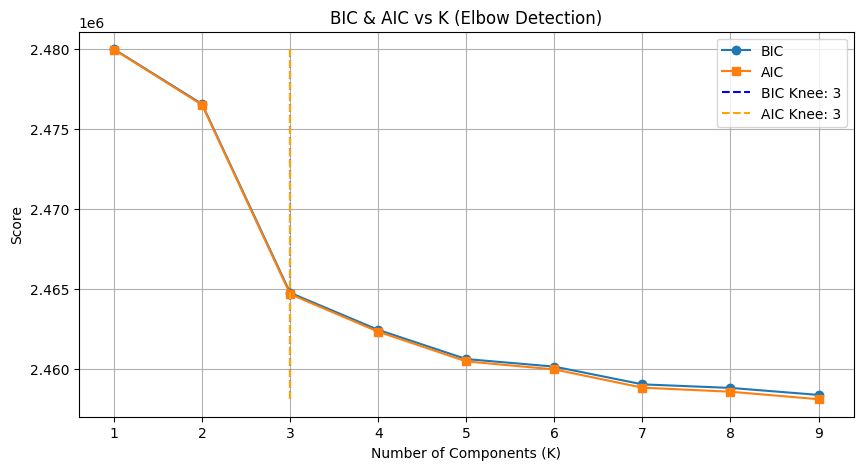

In [242]:
plt.figure(figsize=(10,5))
plt.plot(ks, bics, marker='o', label='BIC')
plt.plot(ks, aics, marker='s', label='AIC')
plt.vlines(knee_bic.knee, min(bics+aics), max(bics+aics), colors='blue', linestyles='dashed', label=f'BIC Knee: {knee_bic.knee}')
plt.vlines(knee_aic.knee, min(bics+aics), max(bics+aics), colors='orange', linestyles='dashed', label=f'AIC Knee: {knee_aic.knee}')
plt.xlabel('Number of Components (K)')
plt.ylabel('Score')
plt.title('BIC & AIC vs K (Elbow Detection)')
plt.legend()
plt.grid(True)
plt.show()

# 9. Fit GMM with Optimal K

In [243]:
best_k = knee_bic.knee
gmm_best = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm_best.fit(X)
labels_best = gmm_best.predict(X)
segmented_best = labels_best.reshape(L_blur.shape)

# 10. Acetowhite Identification

In [ ]:
means = gmm_best.means_.flatten()
acetowhite_label = np.argmax(means)
print(f"Component Means: {means}")
print(f"Acetowhite Cluster Label: {acetowhite_label}")

acetowhite_mask = (segmented_best == acetowhite_label).astype(np.uint8)

L_thresh = 150
acetowhite_mask = acetowhite_mask & (L_blur > L_thresh)

Component Means: [ 98.63244535 214.7248461  148.95076216]
Acetowhite Cluster Label: 1


# 11. Repair Mask With Morphology

In [245]:
kernel = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(acetowhite_mask, cv2.MORPH_OPEN, kernel)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

# 12. Crop Acetowhite Region Only

In [246]:
acetowhite_mask_uint8 = (mask_clean * 255).astype(np.uint8)
acetowhite_mask_3ch = cv2.merge([acetowhite_mask_uint8]*3)
cropped_lesion = cv2.bitwise_and(img_rgb, acetowhite_mask_3ch)

# 13. Visualization

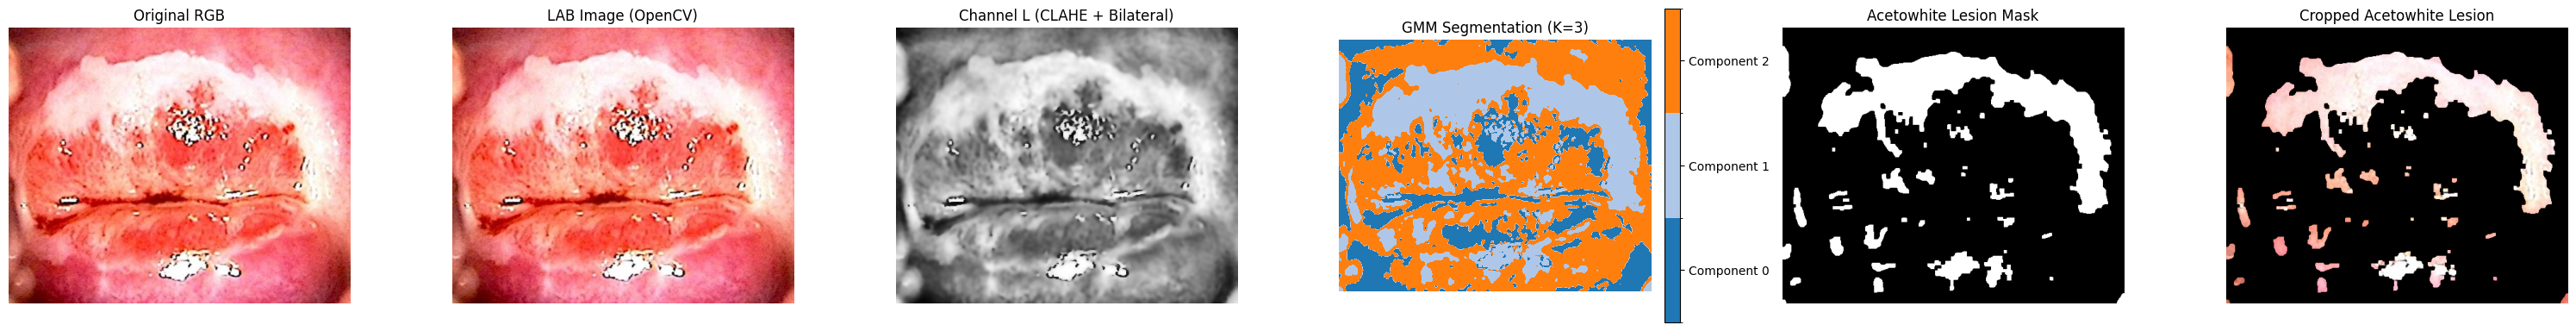

In [247]:
colors = sns.color_palette('tab20', int(best_k)).as_hex()
cmap = ListedColormap(colors)
bounds = np.arange(-0.5, int(best_k) + 0.5, 1)
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 6, figsize=(30, 5))

# Panel 1: RGB
ax[0].imshow(img_rgb)
ax[0].set_title('Original RGB')
ax[0].axis('off')

# Panel 2: LAB
ax[1].imshow(cv2.cvtColor(lab_cv2, cv2.COLOR_LAB2RGB))
ax[1].set_title('LAB Image (OpenCV)')
ax[1].axis('off')

# Panel 3: L channel
ax[2].imshow(L_blur, cmap='gray')
ax[2].set_title('Channel L (CLAHE + Bilateral)')
ax[2].axis('off')

# Panel 4: GMM Segmentation
im = ax[3].imshow(segmented_best, cmap=cmap, norm=norm)
ax[3].set_title(f'GMM Segmentation (K={best_k})')
ax[3].axis('off')
cbar = fig.colorbar(im, ax=ax[3], fraction=0.046, pad=0.04, ticks=range(int(best_k)))
cbar.ax.set_yticklabels([f'Component {i}' for i in range(int(best_k))])

# Panel 5: Mask
ax[4].imshow(mask_clean, cmap='gray')
ax[4].set_title('Acetowhite Lesion Mask')
ax[4].axis('off')

# Panel 6: Crop
ax[5].imshow(cropped_lesion)
ax[5].set_title('Cropped Acetowhite Lesion')
ax[5].axis('off')

plt.tight_layout()
plt.show()

# 14. PDF GMM + Histogram

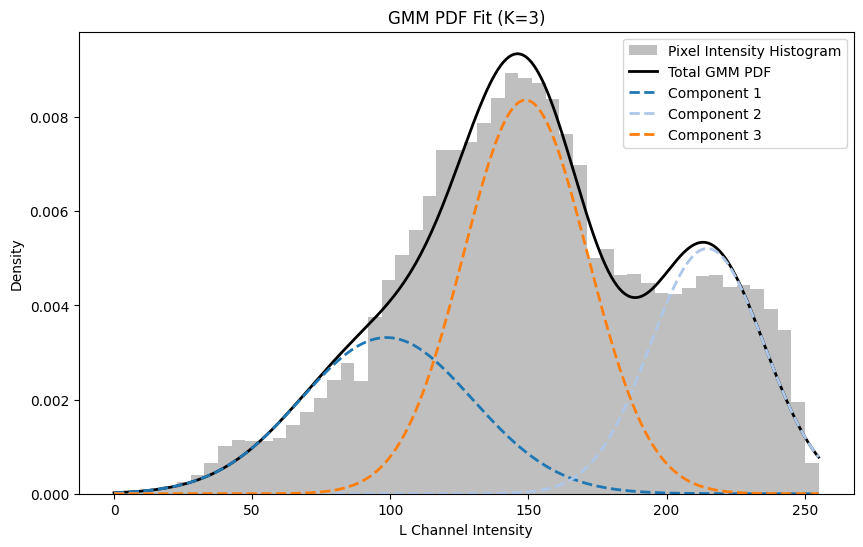

In [248]:
x = np.linspace(0, 255, 256).reshape(-1, 1)
logprob = gmm_best.score_samples(x)
pdf = np.exp(logprob)

responsibilities = gmm_best.predict_proba(x)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(10, 6))
plt.hist(X.flatten(), bins=50, density=True, alpha=0.5, color='gray', label='Pixel Intensity Histogram')
plt.plot(x, pdf, '-k', label='Total GMM PDF', linewidth=2)

for i in range(best_k):
    plt.plot(x, pdf_individual[:, i], '--', color=colors[i], linewidth=2, label=f'Component {i+1}')

plt.xlabel('L Channel Intensity')
plt.ylabel('Density')
plt.title(f'GMM PDF Fit (K={best_k})')
plt.legend()
plt.show()